转换后的数据形状: (43776, 337)
训练集形状: (35020, 24, 14) 测试集形状: (8756, 24, 14)
Epoch 1/100


C:\Users\86132\AppData\Local\Temp\ipykernel_18956\3905161338.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
d:\Python\11\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0458 - val_loss: 0.0377 - learning_rate: 0.0010
Epoch 2/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0225 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 3/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0185 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 4/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0169 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 5/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0149 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 6/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0146 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 7/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0146 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 8/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0147 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 9/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0149 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 10/100


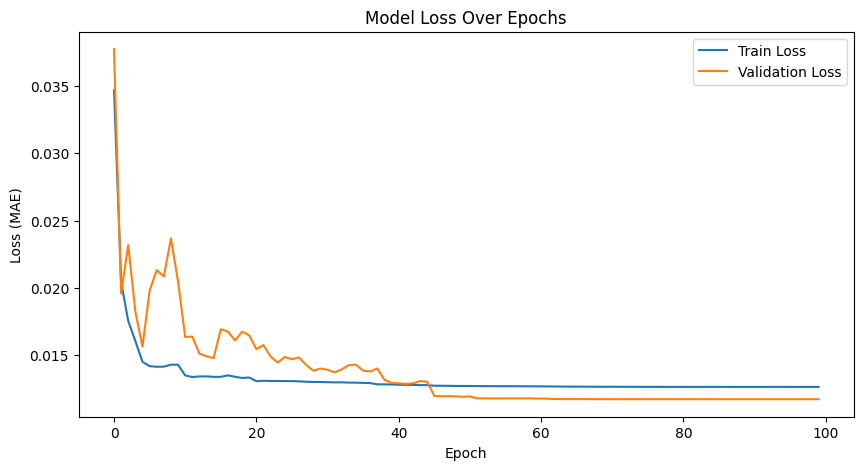

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test RMSE: 23.538
Test MAE: 11.665
Test R² Score: 0.937


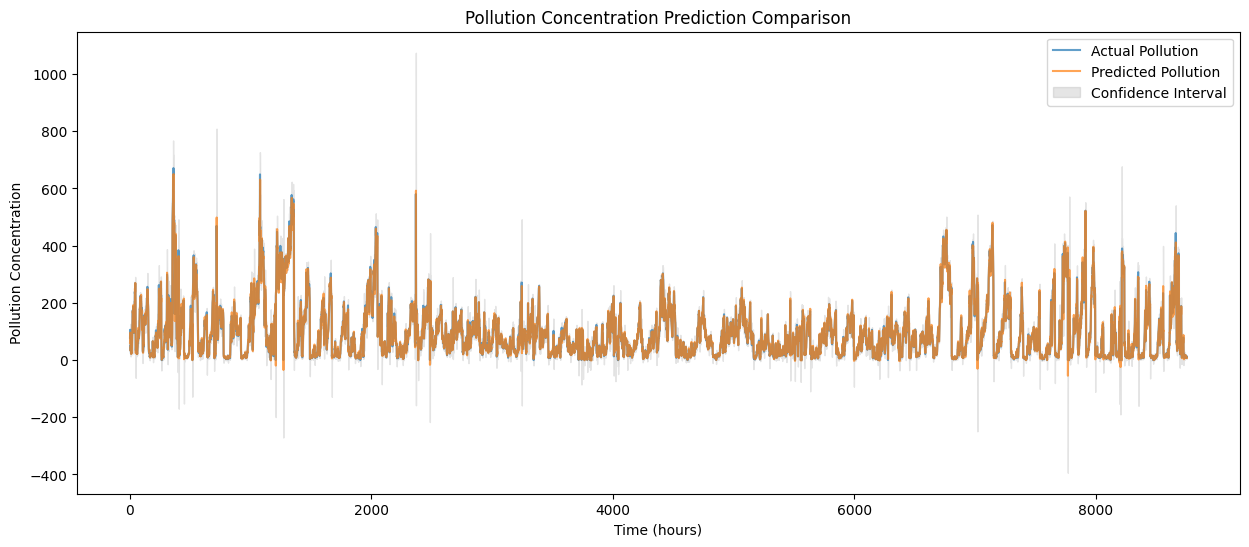

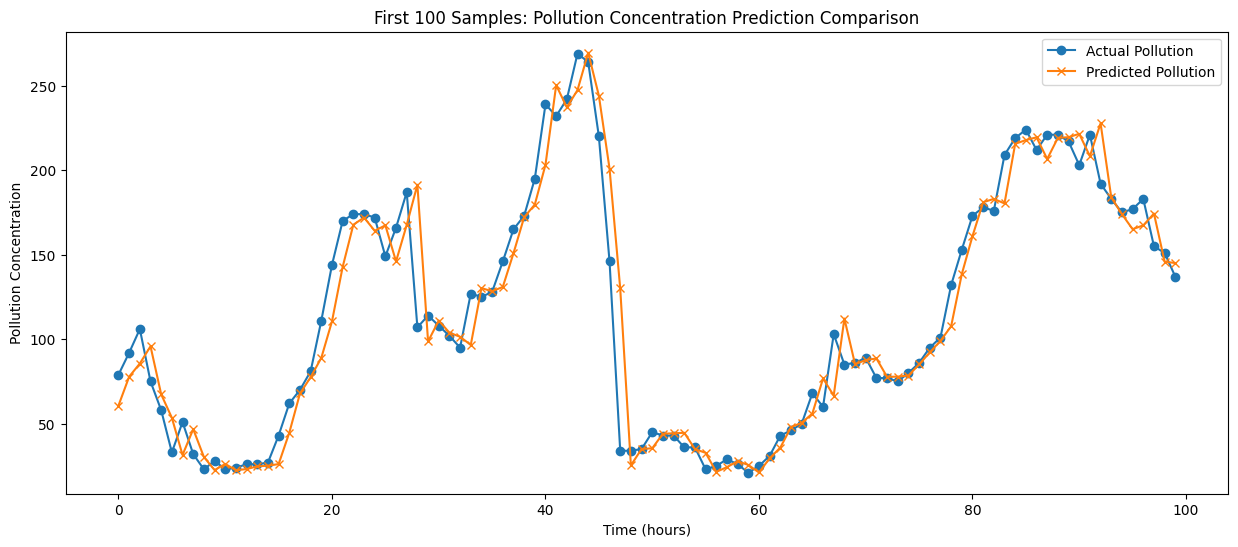

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf

# 1. 数据准备和预处理
# 加载数据
df = pd.read_csv('LSTM-Multivariate_pollution.csv', parse_dates=['date'], index_col='date')

# 处理缺失值
df.fillna(method='ffill', inplace=True)

# 提取时间特征
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # 周一=0, 周日=6
df['month'] = df.index.month

# 对风向进行独热编码
encoder = OneHotEncoder(sparse_output=False)
wind_dir_encoded = encoder.fit_transform(df[['wnd_dir']])
wind_dir_encoded_df = pd.DataFrame(wind_dir_encoded, 
                                   columns=encoder.get_feature_names_out(['wnd_dir']),
                                   index=df.index)

# 合并编码后的风向特征
df = pd.concat([df, wind_dir_encoded_df], axis=1)

# 选择特征列 - 包括时间特征和编码后的风向
features = ['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 
            'hour', 'day_of_week', 'month'] + list(wind_dir_encoded_df.columns)
            
# 移除原始的风向列
df = df.drop('wnd_dir', axis=1)

# 转换为numpy数组
values = df[features].values.astype('float32')

# 归一化数据
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# 特征选择
selector = SelectKBest(score_func=f_regression, k=14)
scaled = selector.fit_transform(scaled, df['pollution'])


# 2. 转换为监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # 输入序列 (t-n, ... t-1)       
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # 预测序列 
    cols.append(df.shift(0).iloc[:, 0])  
    names += ['pollution(t)']
    
    # 合并
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # 删除包含NaN的行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 定义时间步长（用前24小时的数据预测下一小时）
n_hours = 24
n_features = len(features)

# 转换为监督学习问题
reframed = series_to_supervised(scaled, n_hours, 1)
print("转换后的数据形状:", reframed.shape)

# 3. 划分训练集和测试集
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# 划分输入和输出
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1] 
test_X, test_y = test[:, :n_obs], test[:, -1]

# 重塑为3D格式 [样本, 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("训练集形状:", train_X.shape, "测试集形状:", test_X.shape)

# 4. 构建LSTM模型
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# 早停法和动态学习率调整
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 训练模型
history = model.fit(train_X, train_y, epochs=100, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    callbacks=[early_stopping, reduce_lr], 
                    verbose=1, shuffle=False)

# 保存最佳模型
model.save('best_model.h5')

# 绘制训练和验证损失
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 5. 模型评估
# 进行预测
yhat = model.predict(test_X)

# 准备反向归一化的数据
temp_test_X = test_X.reshape((test_X.shape[0], n_hours * n_features))

# 创建反向归一化的框架
inv_yhat = np.zeros((len(yhat), n_features))
inv_yhat[:, 0] = yhat.flatten()
# 其他列使用最后一个时间步的值
inv_yhat[:, 1:] = temp_test_X[:, -n_features+1:]

# 反向归一化
inv_yhat = scaler.inverse_transform(inv_yhat)
predicted_pollution = inv_yhat[:, 0]

# 处理实际值
test_y_reshaped = test_y.reshape(-1, 1)
inv_y = np.zeros((len(test_y_reshaped), n_features))
inv_y[:, 0] = test_y_reshaped.flatten()
inv_y[:, 1:] = temp_test_X[:, -n_features+1:]
inv_y = scaler.inverse_transform(inv_y)
actual_pollution = inv_y[:, 0]

# 计算评估指标
rmse = np.sqrt(mean_squared_error(actual_pollution, predicted_pollution))
mae = mean_absolute_error(actual_pollution, predicted_pollution)
r2 = r2_score(actual_pollution, predicted_pollution)
print(f'Test RMSE: {rmse:.3f}')
print(f'Test MAE: {mae:.3f}')
print(f'Test R² Score: {r2:.3f}')

# 绘制预测结果和实际值对比图
plt.figure(figsize=(15, 6))
plt.plot(actual_pollution, label='Actual Pollution', alpha=0.7)
plt.plot(predicted_pollution, label='Predicted Pollution', alpha=0.7)
plt.fill_between(range(len(actual_pollution)), 
                 actual_pollution - np.abs(actual_pollution - predicted_pollution), 
                 actual_pollution + np.abs(actual_pollution - predicted_pollution), 
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Pollution Concentration Prediction Comparison')
plt.xlabel('Time (hours)')
plt.ylabel('Pollution Concentration')
plt.legend()
plt.show()

# 绘制前100个样本的预测结果和实际值对比图
plt.figure(figsize=(15, 6))
plt.plot(actual_pollution[:100], label='Actual Pollution', marker='o')
plt.plot(predicted_pollution[:100], label='Predicted Pollution', marker='x')
plt.title('First 100 Samples: Pollution Concentration Prediction Comparison')
plt.xlabel('Time (hours)')
plt.ylabel('Pollution Concentration')
plt.legend()
plt.show()